In [1]:
import unittest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utility import *
from tools import *
from maps import *
from measure_properties import *

In [12]:

""" Unit testing.
    The following code tests the functionality of various classes and methods
    and prints the results ('ok' if they match PhotoZ expected outputs, 
                                FAIL or ERROR if they don't).
"""
test_zda_1 = 'test_data/01_02_03.zda'
test_roi_1 = 'test_data/1_rois.dat'
test_traces_1 = 'test_data/Traces1.dat'

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

test_traces_1_data = read_dat_trace_file(test_traces_1)

# Parameters Setting.
startPt = 96
numPt = 50
basePt = 96
skipPt = 30
tools = Tools()
maps = Maps()

# Load and preprocess the Data.
'''
From PhotoZ: The order is data inversing, RLI dividing, temporal filtering,
amplitude correcting, spatial filtering, baseline correction
	dataInversing();
	rliDividing();
	temporalFiltering();
	...
	sp->spatialFilter();
	sp->baseLineCorrection();
'''
data_no_rli_div = DataLoader(test_zda_1,
                             number_of_points_discarded=24).get_data(rli_division=False) # Trials * height * width * timepoints.
data_no_rli_div = tools.T_filter(Data=data_no_rli_div)
data_no_rli_div = tools.S_filter(sigma=1, Data=data_no_rli_div)
data_no_rli_div = tools.Polynomial(startPt=basePt, numPt=skipPt, Data=data_no_rli_div)

#rois = ROIFileReader(test_roi_1).get_roi_list()

trace1 = TraceSelector(data_no_rli_div).get_trace_from_roi([[57,25]])  # Get trace from first ROI.
trace2 = TraceSelector(data_no_rli_div).get_trace_from_roi([[44,33]])  # Get trace from second ROI.


In [13]:
print(np.min(trace1))
print(np.min(trace2))

-1.195189989240768
-1.484417325224672


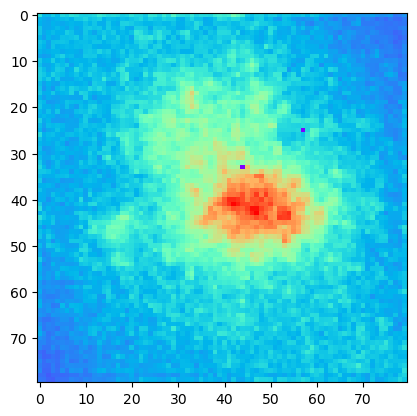

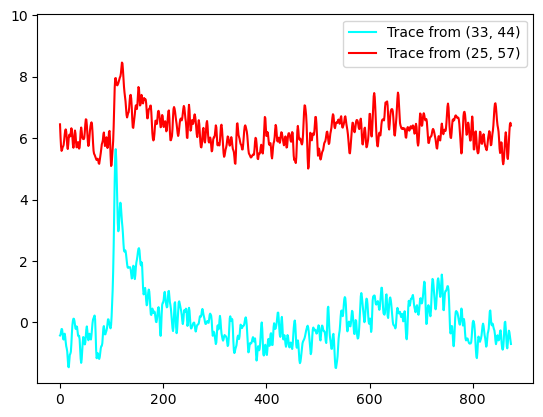

columns in test_traces_1_data: Index(['Pt', 'D2057', 'D2684'], dtype='object')


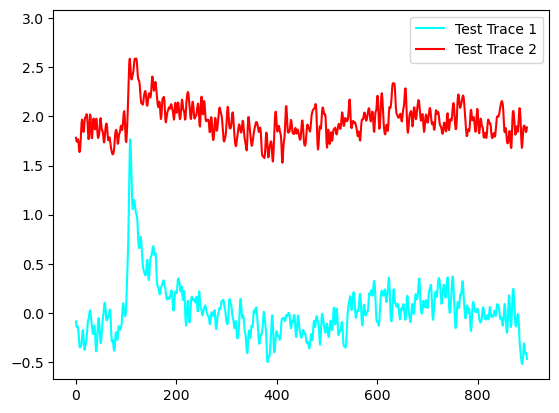

In [ ]:
stim_time = 96

arr = np.max(data_no_rli_div, axis=(0,3))
# blank out [57, 25] and [44, 33] to mark their locations
arr[25,57] = 0
arr[33,44] = 0
plt.imshow(arr, cmap='rainbow')
plt.show()

# show the traces at those locations
plt.plot(trace2, label='Trace from (33, 44)', c='cyan')
plt.plot(trace1 + np.max(trace2) * 1.1, label='Trace from (25, 57)', c='red')
# raise ylim 10%
ylims = plt.gca().get_ylim()
plt.ylim(ylims[0], ylims[1] + (ylims[1]-ylims[0]) * 0.1)
#mark stim time
plt.legend()
plt.show()
print("columns in test_traces_1_data:", test_traces_1_data.columns)
# compare to test_traces_1_data
plt.plot(test_traces_1_data['D2684'], label='Test Trace 1', c='cyan')
plt.plot(test_traces_1_data['D2057'] + np.max(test_traces_1_data['D2684']) * 1.1, label='Test Trace 2', c='red')
# raise ylim 10%
ylims = plt.gca().get_ylim()
plt.ylim(ylims[0], ylims[1] + (ylims[1]-ylims[0]) * 0.1)
plt.legend()
plt.show()

In [15]:
# Test the MeasureProperties class to validate against
# values extracted via PhotoZ.

decimal_precision = 3  # number of decimal places to check
class TestROIFileReader(unittest.TestCase):

    def test_roi_diode_num_converter(self):
        diode_num1 = 2057
        diode_num2 = 2684
        x_px1, y_px1 = ROIFileReader(None).diode_num_to_points([diode_num1])[0]
        x_px2, y_px2 = ROIFileReader(None).diode_num_to_points([diode_num2])[0]
        self.assertEqual((x_px1, y_px1), (25, 57),
                         msg="Diode number 2057 did not convert to expected "
                         "(x,y) coordinates.")
        self.assertEqual((x_px2, y_px2), (33, 44),
                         msg="Diode number 2684 did not convert to expected "
                         "(x,y) coordinates.")
        
class TestMeasureProperties(unittest.TestCase):

    # assertAlmostEqual(first, second, places=7, msg=None, delta=None)

    def test_length_traces_no_rli_division(self):
        length1 = len(trace1)
        len_expected1 = len(test_traces_1_data['D2057'])
        self.assertEqual(length1, len_expected1,
                         msg="Length of trace 1 without RLI division, " + str(length1) + \
                         ", does not match expected value.")
        length2 = len(trace2)
        len_expected2 = len(test_traces_1_data['D2684'])
        self.assertEqual(length2, len_expected2,
                         msg="Length of trace 2 without RLI division, " + str(length2) + \
                         ", does not match expected value.")

    def test_max_amp_no_rli_division(self):
        max_amp1 = TraceProperties(trace1, startPt, numPt, 0.5).get_max_amp()
        self.assertAlmostEqual(max_amp1, 0.645248, places=decimal_precision,
                               msg="Max amplitude for trace 1 without RLI division does not match expected value.")
        max_amp2 = TraceProperties(trace2, startPt, numPt, 0.5).get_max_amp()
        self.assertAlmostEqual(max_amp2, 1.76777, places=decimal_precision,
                               msg="Max amplitude for trace 2 without RLI division does not match expected value.")

    def test_half_width_no_rli_division(self):
        half_width1 = TraceProperties(trace1, startPt, numPt, 0.5).get_half_width()
        self.assertAlmostEqual(half_width1, 12.0453, places=decimal_precision,
                               msg="Half width for trace 1 without RLI division does not match expected value.")
        half_width2 = TraceProperties(trace2, startPt, numPt, 0.5).get_half_width()
        self.assertAlmostEqual(half_width2, 9.35652, places=decimal_precision,
                               msg="Half width for trace 2 without RLI division does not match expected value.")
        
    def test_latency_no_rli_division(self):
        latency1 = TraceProperties(trace1, startPt, numPt, 0.5).get_half_amp_latency()
        self.assertAlmostEqual(latency1, 52.1217, places=decimal_precision,
                               msg="Latency for trace 1 without RLI division does not match expected value.")
        latency2 = TraceProperties(trace2, startPt, numPt, 0.5).get_half_amp_latency()
        self.assertAlmostEqual(latency2, 52.2692, places=decimal_precision,
                               msg="Latency for trace 2 without RLI division does not match expected value.")

    def test_snr_no_rli_division(self):
        snr1 = TraceProperties(trace1, startPt, numPt, 0.5).get_SNR()
        self.assertAlmostEqual(snr1, 8.10524, places=decimal_precision,
                               msg="SNR for trace 1 without RLI division does not match expected value.")
        snr2 = TraceProperties(trace2, startPt, numPt, 0.5).get_SNR()
        self.assertAlmostEqual(snr2, 13.2091, places=decimal_precision,
                               msg="SNR for trace 2 without RLI division does not match expected value.")

if __name__ == '__main__':
    runner = unittest.main(argv=[''], exit=False, verbosity=1)

FFFFF.
FAIL: test_half_width_no_rli_division (__main__.TestMeasureProperties)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\jjudge3\AppData\Local\Temp\ipykernel_41308\3601454564.py", line 45, in test_half_width_no_rli_division
    self.assertAlmostEqual(half_width1, 12.0453, places=decimal_precision,
AssertionError: 10.322857205038488 != 12.0453 within 3 places (1.7224427949615109 difference) : Half width for trace 1 without RLI division does not match expected value.

FAIL: test_latency_no_rli_division (__main__.TestMeasureProperties)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\jjudge3\AppData\Local\Temp\ipykernel_41308\3601454564.py", line 53, in test_latency_no_rli_division
    self.assertAlmostEqual(latency1, 52.1217, places=decimal_precision,
AssertionError: 52.7345370699716 != 52.1217 within 3 places (0.6128370699716044 differ